In [1]:
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()
from glob import glob
from tqdm import tqdm
from collections import Counter
import json, html, re
import numpy as np
import pandas as pd
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from datetime import timedelta, datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
fp = fm.FontProperties(fname=font_path)
    
def clean(text, hashtag=None):
    if hashtag != None:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    text = re.sub(r'ำ([\u0e48\u0e49\u0e4a\u0e4b])', r'\1ำ', text) # am + tone -> tone + am, u0e48 = tone2
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

In [2]:
# List of filepath
jsons = glob('tweets/*.json')
for i, f in enumerate(jsons):
    print(i,f)

0 tweets/#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
1 tweets/#16ตุลาไปแยกปทุมวัน.json
2 tweets/#saveวันเฉลิม.json
3 tweets/#ธรรมศาสตร์และการชุมนุม.json
4 tweets/#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
5 tweets/#25พฤศจิกาไปSCB.json
6 tweets/#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
7 tweets/#ม็อบ2ธันวา.json


In [41]:
### save data as CSV ###
for i in range(8):

    hashtag = jsons[i].split('/')[1].split('.json')[0] 
    df = pd.read_json(jsons[i], lines=True)

    columns = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count', 'retweets_count', 'likes_count']
    df[columns].to_csv(f'tweets/{hashtag}.csv', index=False)

"\n### define duration ###\ndf = df[(df.date >= '2020-11-15') & (df.date <= '2020-11-20')]\ndf = df.reset_index()\n\n### tokenize ###\ndf['tokens'] = df.tweet.apply(lambda x: tokenize(x, hashtag))\n\n### print data ###\nprint('tweets', len(df))\nprint('avg words', df.tokens.apply(len).mean().round(3))\n"

In [6]:
i = 5

hashtag = jsons[i].split('/')[1].split('.json')[0] 
df = pd.read_json(jsons[i], lines=True)

### define duration ###
df = df[(df.date >= '2020-11-24') & (df.date <= '2020-11-26')]
df = df.reset_index()

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x, hashtag))

### print data ###
print('tweets', len(df))
print('avg words', df.tokens.apply(len).mean().round(3))

tweets 48888
avg words 8.778


In [4]:
df

,index,id,conversation_id,created_at,date,time,timezone,user_id,username,name,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens


In [198]:
### save tokenized data ###
df.to_csv('tweets_tokenized/5.csv', index=False)

# associated words

In [20]:
### get most frequent hashtags ###
count = Counter()
for lst in df.hashtags:
    count.update(lst)
hashtags = {x[0]:Counter() for x in count.most_common(16)[1:]}

for i, row in df.iterrows():
    for hashtag in row['hashtags']:
        if hashtag in hashtags:
            hashtags[hashtag].update(row['tokens'])

In [25]:
for k, v in hashtags.items():
    print(k)
    for w, c in v.most_common(10):
        print(f"{w}({c})", end=',')
    print('\n')

อภิปรายไม่ใว้วางใจรัฐบาล
รัฐบาล(831),อภิปราย(824),ใว้(747),วางใจ(747),มข(107),พอกันที(106),เผด็จการ(105),คน(100),สลิ่ม(82),มศวขอ(77),

มขพอกันที
มข(258),พอกันที(253),อภิปราย(158),รัฐบาล(146),ใว้(118),วางใจ(118),เผด็จการ(117),จุดยืน(100),มศวขอ(99),สลิ่ม(89),

อภิปรายไม่ไว้วางใจรัฐบาล
อภิปราย(302),รัฐบาล(298),ไว้วางใจ(250),ใว้(50),วางใจ(50),ทำ(31),คน(28),ประชาชน(27),เผด็จการ(26),สลิ่ม(25),

มศวขอมีจุดยืน
มศวขอ(186),จุดยืน(186),อภิปราย(108),รัฐบาล(103),มข(97),พอกันที(97),ใว้(82),วางใจ(82),เผด็จการ(66),ซีน(56),

ที่ยุบอนาคตใหม่พี่มหาลัยกูทั้งนั้น
พี่(143),อนาคต(140),ยุบ(139),มหาลัย(138),เผด็จการ(36),สลิ่ม(36),ลูก(32),อภิปราย(26),รับใช้(26),รัฐบาล(25),

ธรรมนัส
ธรรม(136),นัส(127),อภิปราย(117),รัฐบาล(75),ใว้(69),วางใจ(69),ไว้วางใจ(46),เผด็จการ(37),ประยุทธ์(21),คน(21),

อภิปรายไม่ใว้วางใจ
อภิปราย(150),ใว้(135),วางใจ(135),เผด็จการ(59),รัฐบาล(47),ธรรม(26),นัส(26),ดำ(19),ไว้วางใจ(19),ประชาธิปไตย(19),

ศิลปากรขอมีซีน
ศิลปากร(109),ซีน(109),มข(64),พอกันที(63),มศวขอ(58),จุดยืน(55),อภิปราย(55),รัฐบาล

# LDA

In [7]:
%%time

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 48888/48888 [00:00<00:00, 55515.49it/s]


CPU times: user 1min 41s, sys: 849 ms, total: 1min 42s
Wall time: 1min 47s


In [8]:
### print result of keywords ###

for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|1|อย่า|0.022|ม็อบ|0.212|ชุมนุม|0.037|ตำรวจ|0.066|คน|0.030|
|2|นะคะ|0.019|พฤศจิกา|0.146|แกง|0.036|ทหาร|0.031|ทำ|0.022|
|3|ขน|0.015|รัฐประหาร|0.034|ถนน|0.019|ประชาชน|0.028|อี|0.019|
|4|แท็ก|0.011|ต่อต้าน|0.028|ตู้|0.016|นะคะ|0.023|อ่ะ|0.014|
|5|เงิน|0.011|พฤศจิกายน|0.011|รถติด|0.015|คน|0.018|เหี้ย|0.014|
|6|พี่|0.011|รถติด|0.009|รถ|0.014|ทำ|0.016|กลัว|0.014|
|7|สู้|0.010|ราษฎร|0.008|ย้าย|0.014|ใส่|0.014|รู้|0.013|
|8|ค่า|0.010|คืน|0.006|นะคะ|0.014|อย่า|0.014|หรอ|0.012|
|9|คน|0.009|ชาติ|0.005|คอนเทนเนอร์|0.013|ขอให้|0.013|เค้า|0.012|
|10|ดัน|0.009|ทวง|0.005|ประกาศ|0.012|น้ำ|0.010|แม่|0.012|


In [9]:
### print distribution (only test, not use) ###

for i in lda.get_document_topics(corpus[:10]):
    print(i)

[(0, 0.6387659), (1, 0.041050173), (2, 0.040021803), (3, 0.04002192), (4, 0.24014027)]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
[(0, 0.09696685), (1, 0.09293545), (2, 0.09299832), (3, 0.09323777), (4, 0.6238616)]
[(0, 0.01363496), (1, 0.29000762), (2, 0.32051134), (3, 0.3618236), (4, 0.01402246)]
[(0, 0.0119251255), (1, 0.07532782), (2, 0.3195203), (3, 0.38122335), (4, 0.21200342)]
[(0, 0.17824309), (1, 0.50926965), (2, 0.07513201), (4, 0.22808187)]
[(0, 0.48761252), (1, 0.044433206), (2, 0.08171575), (4, 0.38029113)]
[(0, 0.018654337), (1, 0.83510673), (2, 0.01829214), (3, 0.10964945), (4, 0.01829735)]
[(0, 0.06557851), (1, 0.27892575), (3, 0.47137928), (4, 0.17452739)]
[(0, 0.9383319), (1, 0.015494261), (2, 0.015391323), (3, 0.015391302), (4, 0.015391243)]


In [10]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet[:n]
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.638789,0.041027,0.040022,0.040022,0.240140,0,คืออะไร งง กูจะสู้เพื่ออะไร.#25พฤศจิกาไปSCB #F...,2020-11-26 23:00
1,0.200000,0.200000,0.200000,0.200000,0.200000,0,https://t.co/2k6QqvfJ2c #ม็อบ27พฤศจิกา #25พฤศ...,2020-11-26 23:00
2,0.650232,0.086717,0.086761,0.086926,0.089364,0,ตามแท้กนี้กันด้วย #อบจอินไซด์ #25พฤศจิกาไปSCB,2020-11-26 23:00
3,0.013635,0.289998,0.320512,0.361834,0.014020,3,จุดหมายจริงๆคืออะไร หรือแค่ป่วน สร้างความรำคาญ...,2020-11-26 23:00
4,0.011925,0.075328,0.319520,0.381226,0.212001,3,กำลังดูข่าวคลิปที่ปย.บอกว่าไม่ได้ใช้ 112 แต่เจ...,2020-11-26 23:00
...,...,...,...,...,...,...,...,...
48883,0.200000,0.200000,0.200000,0.200000,0.200000,0,ไปค่ะ #25พฤศจิกาไปSCB,2020-11-24 22:00
48884,0.000000,0.414915,0.526339,0.044394,0.000000,2,BREAKING: #ม็อบ25พฤศจิกา เปลี่ยนไปสำนักงานใหญ่...,2020-11-24 22:00
48885,0.100010,0.599959,0.100010,0.100010,0.100010,1,ไปคับ #25พฤศจิกาไปSCB,2020-11-24 22:00
48886,0.012510,0.527043,0.435446,0.012501,0.012501,1,BREAKING: #ม็อบ25พฤศจิกา เปลี่ยนไปสำนักงานใหญ่...,2020-11-24 22:00


In [11]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].iterrows():
    if i < len(df)-30 or round(row[0],2) == 0.20:
        continue
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|#25พฤศจิกาไปSCB #ม็อบ25พฤศจิกา|2|0.067|0.733|0.067|0.067|0.067|
|ทุกคนอย่าลืมแจ้งเพื่อนๆที่ไม่ค่อยตามข่าวด้วยนะคะ​ 25นี้เปลี่ยน​สถานที่​ไปตึกเอสซีบีค่า​ #25พฤศจิกาไปSCB|1|0.692|0.015|0.261|0.015|0.015|
|เปลี่ยนแล้วนะทุกคน #ม็อบ25พฤศจิกา #25พฤศจิกาไปSCB #|2|0.067|0.733|0.067|0.067|0.067|
|“ #25พฤศจิกาไปscb “  #ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ  #ม็อบ25พฤศจิกา  #เฮลิคอปเตอร์  #ต่อต้านรัฐประหาร|2|0.015|0.938|0.015|0.015|0.015|
|#25พฤศจิกาไปscb อ่ะ เอาสิ ถือหุ้นใหญ่ก็จัดไป  แต่ๆ ตำรวจเขาจะถอนกำลังทันไหมนะ🤭 #ต่อต้านรัฐประหาร|5|0.020|0.350|0.128|0.138|0.364|
|แกงเก่งงงงง #25พฤศจิกาไปSCB|5|0.040|0.040|0.240|0.040|0.640|
|พรุ่งนี้ไปกินแม็คโดนัลที่เมเจอร์รัชโยดีกว่า #25พฤศจิกาไปSCB|3|0.357|0.020|0.469|0.134|0.020|
|*จะมีทีมงานไปดูแลมวลชนที่ไม่ทราบข่าวแล้วไปอนุสาวรีย์ประชาธิปไตย *โปรดช่วยกันกระจายข่าว! ติดตามข่าวสารจากช่องทางที่เชื่อถือได้ #ม็อบ25พฤศจิกา #25พฤศจิกาไปSCB  https://t.co/bYzXRwN7QT|3|0.011|0.287|0.625|0.066|0.011|
|ขออนุญาตถ

<Figure size 1440x1080 with 0 Axes>

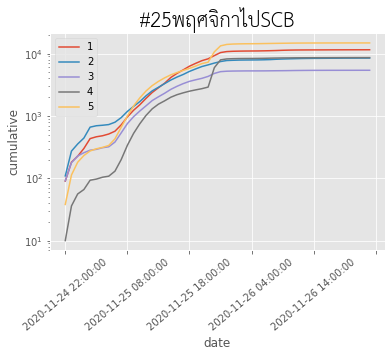

<Figure size 1440x1080 with 0 Axes>

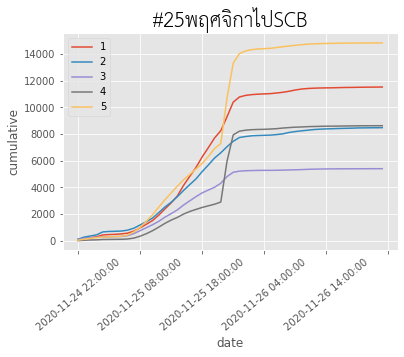

In [14]:
### plot topic time series ###

fig = plt.figure(figsize=(20,15))

tempdf = timerange(df[df.date <= '2020-11-27'])
for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date')
plt.title(hashtag, fontproperties=fp, fontsize=30)
plt.legend()
plt.ylabel('cumulative')
plt.xticks(rotation=40)
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(20,15))

tempdf = timerange(df[df.date <= '2020-11-27'])
for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date')
plt.title(hashtag, fontproperties=fp, fontsize=30)
plt.legend()
plt.ylabel('cumulative')
plt.xticks(rotation=40)
plt.show()

In [234]:
### print frequent user ###

user = 'freeyouthth'

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df.loc[df[df.username == user].index].iterrows():
    if round(row[0],2) == 0.20:
        continue
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|จับกรอกปากพวกมันให้หมดแม่งไอ่สัส รัฐบาลหัวโคยย #ม็อบ17พฤศจิกา #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ #whatshappeninginthailand #ตํารวจทําร้ายประชาชน  #รัฐบาลส้นตีน|3|0.135|0.370|0.424|0.063|0.000|
|อาชีวะ เยาวชนทั้งนั้น ยิงน้องทำไม ไม่ควรยิงใครเลยด้วยซ้ำ  #ม็อบ17พฤศจิกา #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ  #whatishappeninginthailand|4|0.099|0.000|0.156|0.731|0.000|
|#ม็อบ17พฤศจิกา #whatishappeninginthailand #ประชุมสภา #แก้รัฐธรรมนูญ #หยุดคุกคามประชาชน #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ #ThailandProtest2020|3|0.076|0.347|0.396|0.000|0.171|
|"เพื่อชาติ ศาสน์ กษัตริย์ และประชาชน" มึงตัดคำว่า"ประชาชน"ออกไปเลยนะ เพราะพวกมึงไม่เคยทำอะไรเพื่อประชาชนเลย ขนาดหน้าที่ของพวกมึงมึงยังไม่ทำเลย #ม็อบ17พฤศจิกา #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ|2|0.165|0.519|0.011|0.011|0.293|
|#ม็อบ17พฤศจิกา  #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ  #รับทุกร่างคือทางออก  #ม๊อบอยู่บ้านส่งกำลังใจไปช่วย|4|0.304|0.000|0.044|0.635|0.000|
|นี่คือความศรัทธาที่มืดบอด😡 #กูสั่งให้มึงอยู่ใต้รัฐธ

# TF-IDF vectorization + SVD + K-means

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

### prepare data : list of sentences (delimitered by space) -> TF-IDF vectorization
corpus = df.tokens.apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
print(X.shape)

### singular value decomposition & normalize
dim = 50

svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
X = svd.fit_transform(X)
normalized = [vec/np.linalg.norm(vec) if np.linalg.norm(vec) != 0 else np.zeros(dim) for vec in X ]

(49050, 20000)


In [15]:
### clustering 
num = 5

result = KMeans(n_clusters=num).fit_predict(normalized)

In [16]:
print("|tweet|topic|\n|:-:|:-:|")
for _ in range(30):
    i = np.random.randint(0, len(X))
    print(f"|{df.tweet[i]}|{result[i]+1}|")

|tweet|topic|
|:-:|:-:|
|ทุกคนใครไม่เกี่ยวรีบกลับบ้านเลยนะ เดี๋ยวพวกมันสร้างสถานะการณ์อีก #25พฤศจิกาไปSCB|4|
|ตร.จ่อหมายจับอาชีวะมือปืนป่วนม็อบ ยันยิงกันเอง-ปมเรื่องส่วนตัวไม่เกี่ยวชุมนุม  https://t.co/jG6TIc1t4T #25พฤศจิกาไปSCB #ทําในสิ่งที่ดีทําในสิ่งที่ถูก #ประชุมสภา #ม็อบ26พฤศจิกา #มือลั่นเหมือนพ่อมึงเลย #กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ #ส่งต่อคสอ #ตลาดนัดtreasure #ตํารวจไทยขยะสังคม|3|
|LIVE! การชุมนุมบริเวณอาคาร SCB รัชโยธิน #25พฤศจิกาไปSCB  https://t.co/SjnWPQQaQP ผ่าน @YouTube|3|
|ลุ้นให้ย้ายสถานที่อีกค่ะ แกงมันอีก สนุกดี #25พฤศจิกาไปSCB|4|
|CHILD IN MOB ในม็อบมีเด็ก #ม็อบ25พฤศจิกา #25พฤศจิกาไปSCB  https://t.co/X9RRwobovs|2|
|ตึกข้างบนก็มีทะเลดาวด้วยกัน5555555 พวกเราสู้ไปด้วยกันนะคะ #25พฤศจิกาไปSCB  https://t.co/vs33L00y3g|5|
|เสนอเล่นๆนะ ตอนนี้กำลังส่วนใหญ่อยู่ในกรุงเทพ ทั้งจนท ทั้งคนที่เกณฑ์ไป ถ้ามองเกมแล้วคือกะว่ายังไงต้องให้เกิดความรุนแรงแน่ๆ ถ้าวันนี้ยกเลิกม็อบ SCB กะทันหันก็ดีนะ แล้วเปลี่ยนเป็นม็อบตามเมืองใหญ่ต่างจังหวัด ประกาศซักตอน11โมงงี้ เราว่ามันอิมแพคเยอะอยู่นะ #25พฤศจ

In [55]:
a = "ซำ้"
b = "ซ้ำ"

a == b

False

In [56]:
clean(a) == clean(b)

True

In [57]:
clean(a)

'ซ้ำ'